In [1]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [6]:
cd UOC/comp vision/styles/

[Errno 2] No such file or directory: 'UOC/comp vision/styles/'
/content/drive/MyDrive/UOC/comp vision


In [8]:
ls

pic1.jpeg  pic3.jpg  pic5.jpg  pic7.jpeg  pic9.jpg
pic2.webp  pic4.png  pic6.jpg  pic8.webp


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


def preprocess_image(image_path, target_size=(400, 400)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR to RGB
    return np.clip(x / 255.0, 0, 1)

def gram_matrix(tensor):
    x = tf.transpose(tensor, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

content_path = 'pic1.jpeg'
style_path = 'cubism.webp'

content_image = preprocess_image(content_path)
style_image = preprocess_image(style_path)
generated_image = tf.Variable(content_image, dtype=tf.float32)

In [12]:

#vgg
vgg = vgg19.VGG19(weights='imagenet', include_top=False)
vgg.trainable = False

content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

#feature extraction
outputs = [vgg.get_layer(name).output for name in style_layers + [content_layer]]
model = Model(inputs=vgg.input, outputs=outputs)
model.trainable = False

#loss func
def compute_loss(generated, style, content):
    generated_outputs = model(generated)
    style_outputs = model(style)
    content_outputs = model(content)

    # Style loss
    style_loss = 0
    for gen, sty in zip(generated_outputs[:5], style_outputs[:5]):
        gram_gen = gram_matrix(gen[0])
        gram_style = gram_matrix(sty[0])
        style_loss += tf.reduce_mean(tf.square(gram_gen - gram_style))

    # Content loss
    content_loss = tf.reduce_mean(tf.square(generated_outputs[5][0] - content_outputs[5][0]))

    total_loss = 1e-2 * style_loss + content_loss
    return total_loss


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
opt = tf.optimizers.Adam(learning_rate=5.0)

@tf.function()
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, style_image, content_image)
    grad = tape.gradient(loss, generated_image)
    opt.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, -128.0, 128.0))


epochs = 500
for i in range(epochs):
    train_step()
    print(f"Iteration {i} completed")


Iteration 0 completed
Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Iteration 4 completed
Iteration 5 completed
Iteration 6 completed
Iteration 7 completed
Iteration 8 completed
Iteration 9 completed
Iteration 10 completed
Iteration 11 completed
Iteration 12 completed
Iteration 13 completed
Iteration 14 completed
Iteration 15 completed
Iteration 16 completed
Iteration 17 completed
Iteration 18 completed
Iteration 19 completed
Iteration 20 completed
Iteration 21 completed
Iteration 22 completed
Iteration 23 completed
Iteration 24 completed
Iteration 25 completed
Iteration 26 completed
Iteration 27 completed
Iteration 28 completed
Iteration 29 completed
Iteration 30 completed
Iteration 31 completed
Iteration 32 completed
Iteration 33 completed
Iteration 34 completed
Iteration 35 completed
Iteration 36 completed
Iteration 37 completed
Iteration 38 completed
Iteration 39 completed
Iteration 40 completed
Iteration 41 completed
Iteration 42 completed
Iteration 43 complete

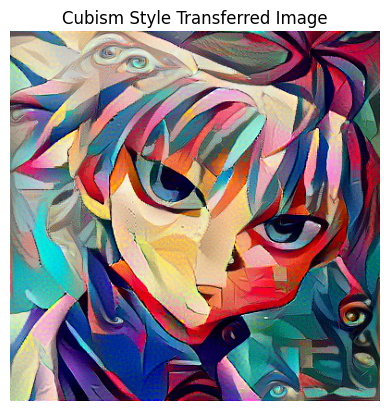

In [20]:

output = deprocess_image(generated_image.numpy())
plt.imshow(output)
plt.axis('off')
plt.title('Cubism Style Transferred Image')
plt.show()


In [27]:
# Fast Style Transfer (Train + Stylize One Image)

import torch
from torch import nn, optim
from torchvision import models, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from PIL import Image
import os

# --- Transformer Network ---4f
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, 3, 1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, 3, 1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        return out + residual

class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.conv1 = ConvLayer(3, 32, 9, 1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, 3, 2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, 3, 2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)

        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)

        self.deconv1 = nn.Upsample(scale_factor=2)
        self.conv4 = ConvLayer(128, 64, 3, 1)
        self.in4 = nn.InstanceNorm2d(64, affine=True)

        self.deconv2 = nn.Upsample(scale_factor=2)
        self.conv5 = ConvLayer(64, 32, 3, 1)
        self.in5 = nn.InstanceNorm2d(32, affine=True)

        self.conv6 = ConvLayer(32, 3, 9, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.in1(self.conv1(x)))
        x = self.relu(self.in2(self.conv2(x)))
        x = self.relu(self.in3(self.conv3(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.relu(self.in4(self.conv4(self.deconv1(x))))
        x = self.relu(self.in5(self.conv5(self.deconv2(x))))
        x = self.conv6(x)
        return x

# --- VGG Loss Network ---
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        vgg_features = models.vgg16(pretrained=True).features
        self.layers = nn.Sequential(*list(vgg_features.children())[:16])
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for layer in self.layers:
            x = layer(x)
            features.append(x)
        return features

# --- Gram Matrix ---
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

# --- Image Utilities ---
def load_image(img_path, transform):
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

def save_stylized_image(tensor, filename):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image.clamp(0, 255)
    image = image / 255
    save_image(image, filename)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content_img_path = "pic1.jpeg"
style_img_path = "cubism.webp"

# --- Transforms ---
img_size = 256
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255)
])

# --- Load Images ---
content_image = load_image(content_img_path, transform)
style_image = load_image(style_img_path, transform)

# --- Initialize Models ---
transformer = TransformerNet().to(device)
vgg = VGG().to(device)

# --- Optimizer ---
optimizer = optim.Adam(transformer.parameters(), lr=1e-3)

# --- Training ---
style_features = vgg(style_image)
style_grams = [gram_matrix(f) for f in style_features]

for epoch in range(50):  # quick test training
    optimizer.zero_grad()
    output = transformer(content_image)
    output_features = vgg(output)
    content_features = vgg(content_image)

    content_loss = 1e5 * nn.MSELoss()(output_features[2], content_features[2])
    style_loss = 0.0
    for of, sg in zip(output_features, style_grams):
        style_loss += nn.MSELoss()(gram_matrix(of), sg)
    style_loss *= 1e10

    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.2f}")

# --- Save Result ---
save_stylized_image(output, "stylized_output.jpg")
print("✅ Stylized image saved as stylized_output.jpg")

Epoch 1, Loss: 6523969960148992.00
Epoch 2, Loss: 6521584642686976.00
Epoch 3, Loss: 6505650314018816.00
Epoch 4, Loss: 6467867486715904.00
Epoch 5, Loss: 6415291181432832.00
Epoch 6, Loss: 6345200536387584.00
Epoch 7, Loss: 6265325955842048.00
Epoch 8, Loss: 6164884387528704.00
Epoch 9, Loss: 6043243934384128.00
Epoch 10, Loss: 5884135797161984.00
Epoch 11, Loss: 5722834005393408.00
Epoch 12, Loss: 5525031970930688.00
Epoch 13, Loss: 5376510928093184.00
Epoch 14, Loss: 5231532696403968.00
Epoch 15, Loss: 5118859598102528.00
Epoch 16, Loss: 5037339508211712.00
Epoch 17, Loss: 4961415223836672.00
Epoch 18, Loss: 4978515636125696.00
Epoch 19, Loss: 4939117901119488.00
Epoch 20, Loss: 4893030217678848.00
Epoch 21, Loss: 4813201271160832.00
Epoch 22, Loss: 4752507477688320.00
Epoch 23, Loss: 4688479715852288.00
Epoch 24, Loss: 4634815173230592.00
Epoch 25, Loss: 4577243284111360.00
Epoch 26, Loss: 4519909228806144.00
Epoch 27, Loss: 4459204161044480.00
Epoch 28, Loss: 4409723185004544.00
E

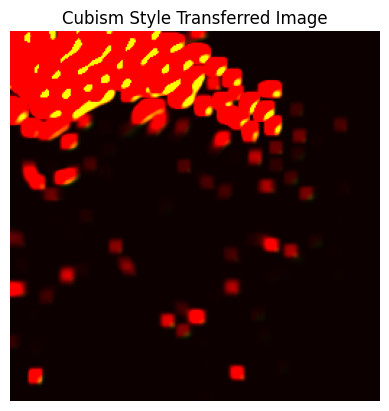

In [28]:
img = output.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.title('Cubism Style Transferred Image')
plt.show()


